In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

In [6]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical

def load_data_from_mat(path):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith('train_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith('test_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels

# 调用函数加载数据
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path)


print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)
print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)

train_data_reshaped = train_data.reshape((-1, 32, 32, 3))
test_data_reshaped = test_data.reshape((-1, 32, 32, 3))


Train data shape: (126000, 3072)
Train labels shape: (126000, 10)
Test data shape: (14000, 3072)
Test labels shape: (14000, 10)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_vgg_like_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential([
        # Block 1
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        # Block 2
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        # Block 3
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# 根据加载的数据设置模型
model = build_vgg_like_model(input_shape=(32, 32, 3), num_classes=10)

# 编译模型
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,248,202 (12.39 MB)

 Trainable params: 3,248,202 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 训练模型
history = model.fit(train_data_reshaped, train_labels,
                    batch_size=64,
                    epochs=30,  # 可以调整为合适的值
                    validation_split=0.1)



Epoch 1/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 397s 223ms/step - accuracy: 0.5783 - loss: 1.0010 - val_accuracy: 0.6498 - val_loss: 0.7048
Epoch 2/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 390s 220ms/step - accuracy: 0.8111 - loss: 0.3993 - val_accuracy: 0.7899 - val_loss: 0.3747
Epoch 3/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 395s 223ms/step - accuracy: 0.8280 - loss: 0.3576 - val_accuracy: 0.8113 - val_loss: 0.3613
Epoch 4/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 384s 217ms/step - accuracy: 0.8368 - loss: 0.3319 - val_accuracy: 0.8539 - val_loss: 0.2565
Epoch 5/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 388s 219ms/step - accuracy: 0.8432 - loss: 0.3118 - val_accuracy: 0.8599 - val_loss: 0.2308
Epoch 6/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 395s 223ms/step - accuracy: 0.8537 - loss: 0.2859 - val_accuracy: 0.8775 - val_loss: 0.2075
Epoch 7/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 405s 228ms/step - accuracy: 0.8607 - loss: 0.2703 - val_accuracy: 0.8599 - val_loss: 0.2507
Epoch 8/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 389s 219ms/step - ac

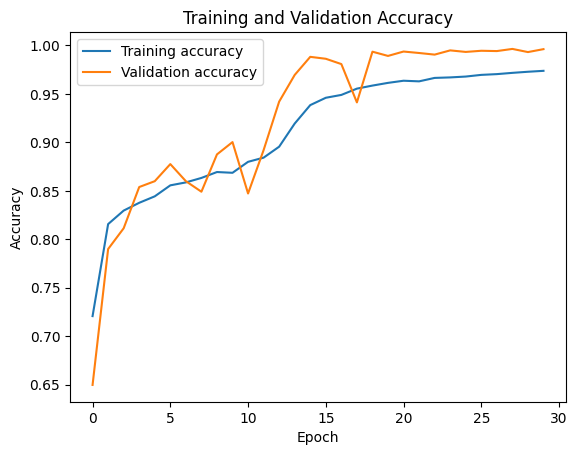

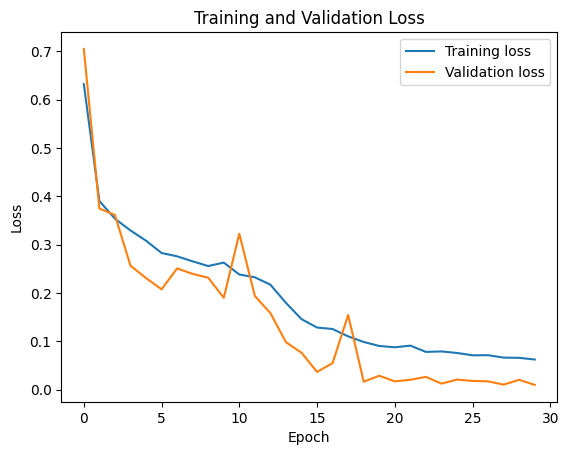

In [9]:
# 可视化训练过程
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
model.save('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/vggNet0330-1.h5')  # HDF5文件


In [11]:
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/vggNet0330-1.h5')
# 评估模型在测试集上的性能
test_loss, test_acc = loaded_model.evaluate(test_data_reshaped, test_labels, verbose=2)

print(f'测试集损失: {test_loss}')
print(f'测试集准确率: {test_acc}')


438/438 - 17s - 39ms/step - accuracy: 0.9702 - loss: 0.0679
测试集损失: 0.06787347793579102
测试集准确率: 0.970214307308197


438/438 - 17s - 39ms/step - accuracy: 0.9702 - loss: 0.0679

Test accuracy: 0.970214307308197
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1400
           1       1.00      1.00      1.00      1400
           2       0.99      1.00      0.99      1400
           3       1.00      0.97      0.99      1400
           4       1.00      1.00      1.00      1400
           5       1.00      1.00      1.00      1400
           6       0.96      0.98      0.97      1400
           7       1.00      1.00      1.00      1400
           8       0.89      0.89      0.89      1400
           9       0.89      0.91      0.90      1400

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



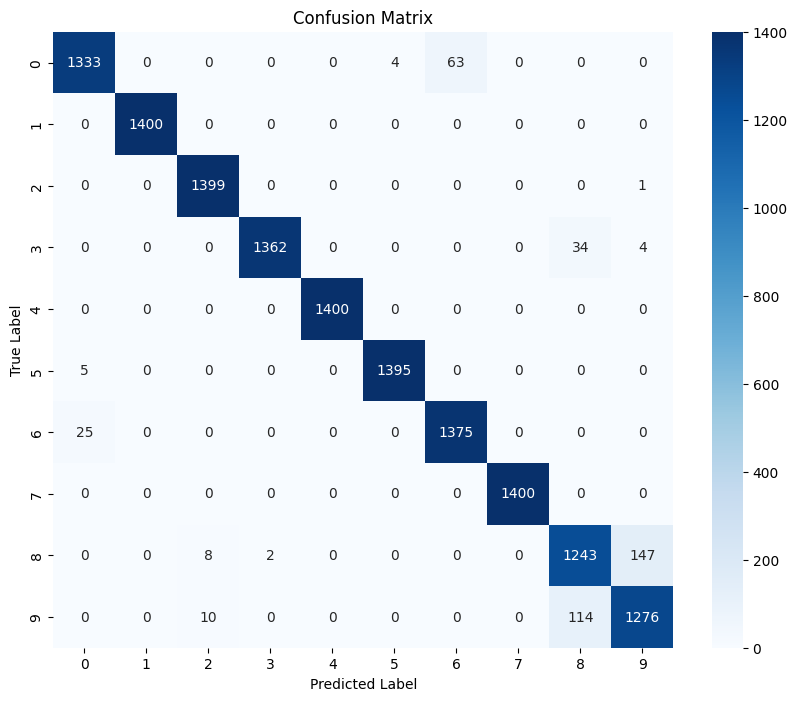

In [12]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
